# Calibração de câmera
## Curso de Fotografia Computacional

### Imports e funções de utilidade

In [ ]:
import numpy as np
import cv2
import glob
import yaml
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def show_image(img, figsize=(30, 15)):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img, cmap="gray")
  plt.show()

def show_images(img_list, figsize=None):
  n = len(img_list)
  if figsize == None:
    figsize = (5 * n, 8)
  fig, ax = plt.subplots(1, n, figsize=figsize)
  for i in range(n):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(img_list[i], cmap="gray")
  plt.show()

### Carregando imagens
Fazer upload do zip no drive (lembre-se de montar o drive no Colab) e alterar o caminho abaixo

In [ ]:
%%capture
!unzip drive/MyDrive/fotocomp/data_edge30ultra.zip -d .

#### Execução da calibração

In [ ]:
# Critérios de paradas
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

CHECKERBOARD = (8, 6) # (altura, largura)
SIZE = 25 #mm

# Construções de possíveis pontos do "mundo"
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0, :, :2] = np.mgrid[:CHECKERBOARD[0], :CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= SIZE

# Listas para pontos do "mundo" e pontos de imagem
objpoints = []
imgpoints = []

files = glob.glob("data_edge30ultra/*")
n_ok = 0
for filename in tqdm(files):
    img = cv2.imread(filename)
    img = cv2.resize(img, None, fx=1/4, fy=1/4)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Encontrar pontos na imagem
    ok, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    if ok:
        n_ok += 1
        objpoints.append(objp)

        # Refinar coordenadas
        corners2 = cv2.cornerSubPix(gray, corners, (4, 4), (-1, -1), criteria)
        imgpoints.append(corners2)

print(f"Percentage of usable images: {n_ok / len(files)}")

# Calibrar camera com os dados encontrados
_, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints,
    imgpoints,
    gray.shape[::-1],
    None,
    None
)

with open('matrix.npy', 'wb') as f:
	np.save(f, mtx)

with open('dist_coeff.npy', 'wb') as f:
	np.save(f, dist)

with open('rvecs.npy', 'wb') as f:
	np.save(f, rvecs)

with open('tvecs.npy', 'wb') as f:
	np.save(f, tvecs)

100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


Percentage of usable images: 1.0


### Remoção de distorção

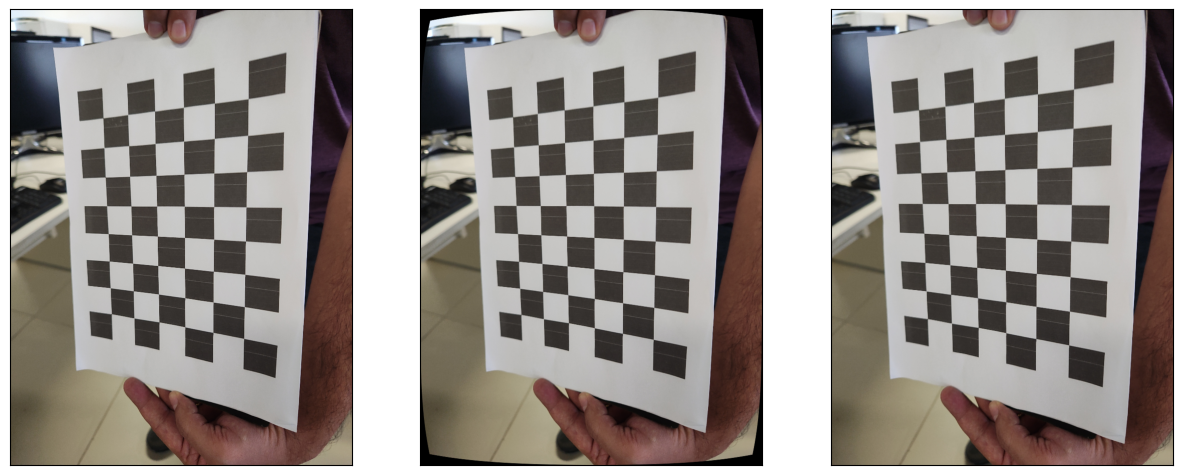

True

In [ ]:
img = cv2.imread(files[np.random.randint(0, len(files))])
img = cv2.resize(img, None, fx=1/4, fy=1/4)
h, w = img.shape[:2]

scaled_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
roi_x, roi_y, roi_w, roi_h = roi
undistorted = cv2.undistort(
    img, mtx, dist, None, scaled_camera_matrix,
)

undistorted_ = undistorted[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]
undistorted_ = cv2.resize(undistorted_, (w, h), interpolation=cv2.INTER_LANCZOS4)
undistorted = cv2.resize(undistorted, (w, h), interpolation=cv2.INTER_LANCZOS4)

show_images([i[..., ::-1] for i in [img, undistorted, undistorted_]])
cv2.imwrite("undistorted.png", undistorted)